In this module, we study how to implement logistic regressions for binary response in Python. 

For this lecture we will be working with the Titanic Data Set from Kaggle. This is a very famous data set and very often is a student's first step in machine learning. The dataset records death information for passengers who died and survived during the Titanic incidence. We'll be trying to predict a classification label for survival or deceased. We will also be learning how to interpret the logistic regression model from a traditional statistician's angle. For convenience, we'll use a semi-cleaned version of the titanic dataset. 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import scipy, scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics

%matplotlib inline

Now let's read in the data and then do some explorative data analysis. 

In [2]:
path='C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\\Introduction to Data Science Using Python\\datasets'
os.chdir(path)
titanic = pd.read_csv('titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
EDA1=titanic.describe()
EDA2=titanic.columns
print(EDA1, '\n')
print(EDA2, '\n')
titanic.info()

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200   

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
    

Here are some potentially confusing variable names:

* SibSp: number of siblings aboard
* Parch: number of parents/children aboard
* Pclass: passenger class

Based on the previosu analsyis, we see there seems to be missing data on the variable 'Age' and 'Cabin'. We can use the 'seaborn' library to create a simple heatmap to see where we are missing data. It can be shown that roughly 20 percent of the 'Age' data is missing. The proportion of 'Age' missing is likely small enough for reasonable replacement with some form of imputation.

However, looking at the 'Cabin' column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0".

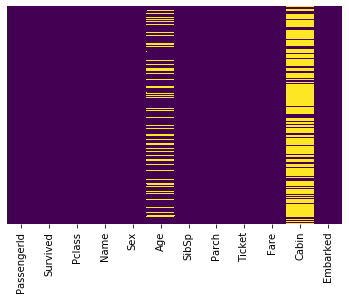

In [4]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Now let's do more frequency analysis on other variables:

AxesSubplot(0.125,0.125;0.775x0.755)


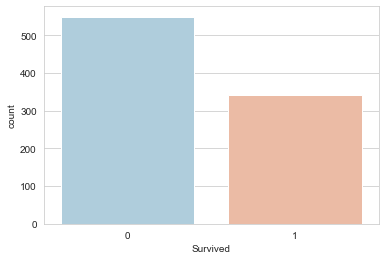

In [5]:
sns.set_style('whitegrid')
print(sns.countplot(x='Survived',data=titanic,palette='RdBu_r'))

AxesSubplot(0.125,0.125;0.775x0.755)


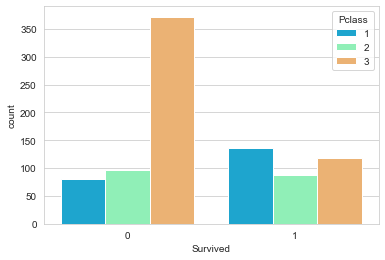

In [6]:
sns.set_style('whitegrid')
print(sns.countplot(x='Survived',hue='Pclass',data=titanic,palette='rainbow'))

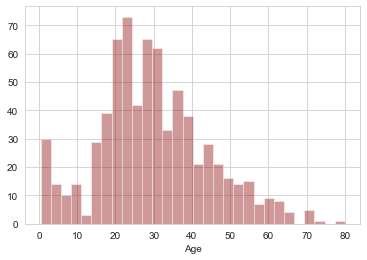

In [7]:
sns.distplot(titanic['Age'].dropna(),kde=False,color='darkred',bins=30)

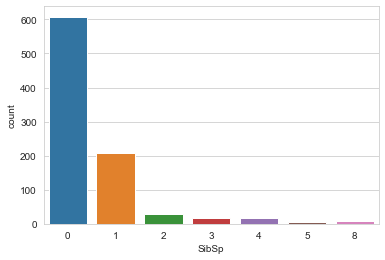

In [8]:
sns.countplot(x='SibSp',data=titanic)

Now let's examine the correlation between 'Age' and 'Fare'. As we shall see, these two variables do not seem to be correlated very much:

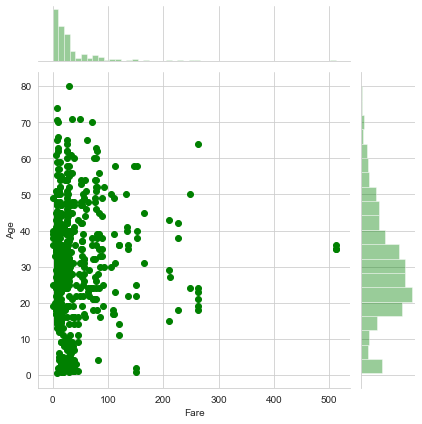

In [9]:
sns.jointplot(x='Fare',y='Age',data=titanic,color='green') # age and fair not related too much

Now let's go back to the problem of missing data. For the variable 'Age', we want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation). We can be smarter about this and check the average age by passenger class:

        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
1       186.0  38.233441  14.802856  0.92  27.0  37.0  49.0  80.0
2       173.0  29.877630  14.001077  0.67  23.0  29.0  36.0  70.0
3       355.0  25.140620  12.495398  0.42  18.0  24.0  32.0  74.0


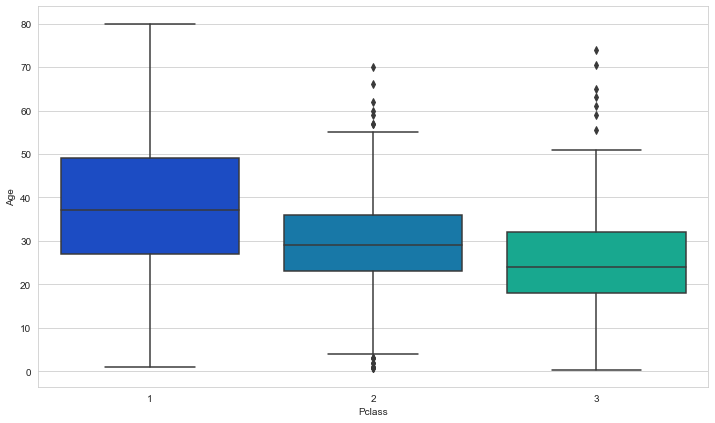

In [10]:
impute_analysis=titanic['Age'].groupby(titanic['Pclass']).describe()
print(impute_analysis)
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=titanic,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on 'Pclass' for 'Age'. Here, the average values of for each class are given by 38.233441, 29.877630, and 25.140620 for classes 1, 2, and 3. Below, we will create a function to impute 'Age' and then apply that function, followed by a post hoc check on the heatmap again:

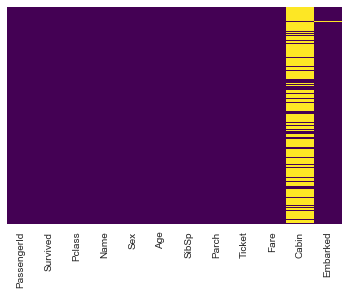

In [11]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]    
    if pd.isnull(Age):
        if Pclass == 1:
            return impute_analysis['mean'].iloc[0]
        elif Pclass == 2:
            return impute_analysis['mean'].iloc[1]
        else:
            return impute_analysis['mean'].iloc[2]
    else:
        return Age
titanic['Age'] = titanic[['Age','Pclass']].apply(impute_age,axis=1)
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Now in the dataset, the only column that has missing values is 'Cabin'. Let's drop this:

In [12]:
titanic.drop('Cabin',axis=1,inplace=True)
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S


The last thing we need to do is to create dummy variables. If we don't do this, our machine learning algorithm won't be able to directly take in those features as inputs. In addition, we will drop two additional variables 'Name' and 'Ticket' as neither of them provides valuable information for modeling in future steps:

In [13]:
sex = pd.get_dummies(titanic['Sex'],drop_first=True) # drop_first drops the first column to avoid multicollinearity
embark = pd.get_dummies(titanic['Embarked'],drop_first=True)
titanic.drop(['Sex','Embarked'],axis=1,inplace=True) # dropping the variable from the original 'DataFrame' object
titanic = pd.concat([titanic,sex,embark],axis=1) # adding in the dummy variable in the remaining 'DataFrame' object
titanic.drop(['Name','Ticket'],axis=1,inplace=True)

Now lets implement logit model from a machine learning perspective. Let's do a training and test data split with 30% test size and create an instance of logit model. We will then obtain the model and the predictions:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(titanic.drop('Survived',axis=1), titanic['Survived'], test_size=0.30, random_state=101)

In [15]:
logmodel = LogisticRegression(C = 1e9) # creating an instance of logistic regression model
logmodel.fit(X_train,y_train) # fitting the data
predictions = logmodel.predict(X_test) # making predictions on the test set

C:\Users\pgao\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Notice that we added an argument C = 1e9. What this does is that we are trying to use logistic regression without any regularization (see here for more information: https://stats.stackexchange.com/questions/203740/logistic-regression-scikit-learn-vs-statsmodels). The default setting for LogisticRegression() is always using regularization with C=1. Using regularization (with higher value of C) in general prevents overfitting. 

Now let's do model evaluation:

In [16]:
print(classification_report(y_test,predictions)) 

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       154
           1       0.78      0.63      0.70       114

    accuracy                           0.77       268
   macro avg       0.77      0.75      0.76       268
weighted avg       0.77      0.77      0.76       268



The model evaluation basically gives us all the important information. Precision-Recall is a useful pair of measures of success of prediction when the classes are very imbalanced. In information retrieval, precision (positive predictive value) is a measure of result of relevancy, while recall (sensitivity, or true positive rate) is a measure of how many truly relevant results are returned. The Precision-Recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). An ideal system with high precision and high recall will return many results, with all results labeled correctly.

* $Precision=\frac{TP}{(TP+FP)}$
* $Recall=\frac{TP}{TP+FN}$ 

Essentially, we can think of false positive (FP) as the type I error (false alarm) and false negative (FN) as the type II error (e.g. a truly guilty prisoner is acquitted of a crime). The true positive (TP) can be thought of as the power of the test (a.k.a. sensitivity), if we make an analogy to the classical hypothesis testing framework. The true negative rate is also called the specificity (1-false positive rate).  

These quantities are also related to the F measure, which is defined as the harmonic mean of precision and recall. An $F_1$ score reaches its best value at 1 (perfect precision and recall) and worst at 0.

* $F_1=\frac{2*Precision*Recall}{Precision+Recall}$

Another important measure is called the accuracy, which is defined as follows:

* $Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$

The problem of the metric 'accuracy' is that it assumes equal cost of both kinds of errors. 

We have examined the logistic regression from the machine learning perspective. Now it's time to look at the problem from a traditional statistical point of view:

In [19]:
logit = sm.Logit(y_train, X_train)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.470118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      614
Method:                           MLE   Df Model:                            8
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                  0.2842
Time:                        16:07:37   Log-Likelihood:                -292.88
converged:                       True   LL-Null:                       -409.17
Covariance Type:            nonrobust   LLR p-value:                 8.438e-46
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
PassengerId     0.0010      0.000      2.491      0.013       0.000       0.002
Pclass         -0.0441      0.109     -0.405      0.686      -0.258       0.169
Age             0.0010      0.007      0.138      0.890      -0.013       0.015
SibSp          -0.2767      0.112     -2.468      0.014      -0.496      -0.057
Parch          -0.1674      0.137     -1.220      0.223      -0.436       0.102
Fare            0.0191      0.004      4.732      0.000       0.011       0.027
male           -2.4680      0.225    -10.985      0.000      -2.908      -2.028
Q               0.2549      0.431      0.591      0.554      -0.590       1.100
S               0.1185      0.269      0.440      0.660      -0.409       0.646
===============================================================================
"""

Here, we see that for a one-unit increase in the 'Fare', the expected change in log odds of a survival is 0.0191 (higher fare implies more likely to survive statistically). 

Resources:
  - http://blog.yhat.com/posts/logistic-regression-and-python.html
  - https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/
  - http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html